In [27]:
import pandas as pd
from matplotlib import pyplot as plt
from scipy.linalg import lstsq
import numpy as np
import pickle
from tqdm import tqdm

In [16]:
def extract_neighborhood(data, i, j):
    """Extracts a 3x3 neighborhood around pixel (i, j)"""
    # Pad data to handle edges
    padded_data = np.pad(data, 1, mode='edge')
    # Make sure to extract so that (i, j) is the center
    return padded_data[i-1:i+2, j-1:j+2].flatten()

def fit_plane(neighborhood):
    """Fits a plane to a 3x3 neighborhood"""
    # Create coordinates for a 3x3 grid centered at (0, 0)
    x, y = np.meshgrid(np.arange(-1, 2), np.arange(-1, 2))
    x = x.flatten()
    y = y.flatten()
    
    # Formulate the least squares problem Ax = b
    A = np.column_stack([x, y, np.ones(9)])
    b = neighborhood
    
    # Solve the least squares problem
    coeffs, residuals, rank, s = lstsq(A, b, lapack_driver='gelsy')
    return coeffs  # Returns [a, b, c] coefficients of the plane


def process_image(data):
    """Applies plane fitting to each pixel using nested loops"""
    rows, cols = data.shape
    coeffs_matrix = np.zeros((rows, cols, 3))  # To store a, b, c coefficients for each pixel

    for i in range(rows):
        for j in range(cols):
            neighborhood = extract_neighborhood(data, i+1, j+1)  # Account for padding in indices
            coeffs = fit_plane(neighborhood)
            # Store the coefficients at the corresponding pixel position
            coeffs_matrix[i, j] = coeffs

    return coeffs_matrix

In [83]:
out = []

# i1, i2, j1, j2 = 58,196,45,185
i1, i2, j1, j2 = 59,196,46,185
for i in tqdm(range(4,14)):
    df = pd.read_csv('manu/B%04d.csv' % i, delimiter=';')
    Nx = int((df['x [pixel]'].max())/8 + 1)

    uy = df['y-displacement [pixel]'].to_numpy()
    ux= df['x-displacement [pixel]'].to_numpy()
    uy = uy.reshape((-1,Nx))
    ux = ux.reshape((-1,Nx))

    ux_coeff = process_image(ux)
    uy_coeff = process_image(uy)

    F = np.stack((ux_coeff[:,:,:2], uy_coeff[:,:,:2]), axis = -1)/8 + np.eye(2)[None,None,:,:]
    F = F[i1:i2, j1:j2]

    F = F.transpose([1,0,2,3])
    temp = F.reshape([-1,2,2])
    # temp = np.array([i*np.ones(len(temp)), temp[:,0,0], temp[:,0,1], temp[:,1,0], temp[:,1,1]])
    out.append(temp)
F_hist = np.array(out)

x = df['x [pixel]'].to_numpy().reshape((-1,Nx))[i1:i2, j1:j2]
y = df['y [pixel]'].to_numpy().reshape((-1,Nx))[i1:i2, j1:j2]
x = (x - x.min())/(x.max() - x.min())
y = (y - y.min())/(y.max() - y.min())

100%|██████████| 10/10 [00:52<00:00,  5.21s/it]


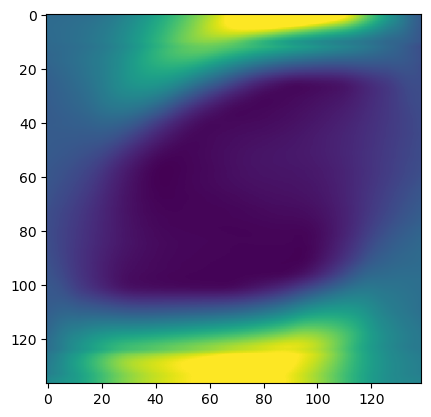

In [84]:
F_T = np.transpose(F, axes=(0, 1, 3, 2))
C = np.einsum('ijkl,ijlm->ijkm', F_T, F)
C = C.transpose([1,0,2,3])
plt.imshow((C[:,:,1,1]-1)*0.5, vmin=0, vmax=0.7)

In [123]:
with open('manu/S.npy', 'wb') as f:
    pickle.dump([x,y,F_hist], f)

### Stiff1_Hetero

In [87]:
out = []

for i in tqdm(range(1,190)):
    df = pd.read_csv('manu/Stiff1_Hetero_Final_42x41/Stiff1_Hetero_Final%04d.csv' % i, delimiter=';')
    Nx = 43

    uy = df['y-displacement [pixel]'].to_numpy()
    ux = df['x-displacement [pixel]'].to_numpy()
    uy = uy.reshape((-1,Nx))
    ux = ux.reshape((-1,Nx))

    ux_coeff = process_image(ux)
    uy_coeff = process_image(uy)

    F = np.stack((ux_coeff[:,:,:2], uy_coeff[:,:,:2]), axis = -1)/8 + np.eye(2)[None,None,:,:]
    F = F[:-1,:-1] # For some reason F is 43x42 whereas Manu says it is 42x41? Plus, the last pixel looks artifacty

    F = F.transpose([1,0,2,3])
    temp = F.reshape([-1,2,2])
    out.append(temp)
F_hist = np.array(out)

x = df['x [pixel]'].to_numpy().reshape((-1,Nx))
y = df['y [pixel]'].to_numpy().reshape((-1,Nx))
x = (x - x.min())/(x.max() - x.min())
y = (y - y.min())/(y.max() - y.min())
x = x[:-1,:-1]  # For some reason F is 43x42 whereas Manu says it is 42x41? Plus, the last pixel looks artifacty
y = y[:-1,:-1]

100%|██████████| 189/189 [00:26<00:00,  7.10it/s]


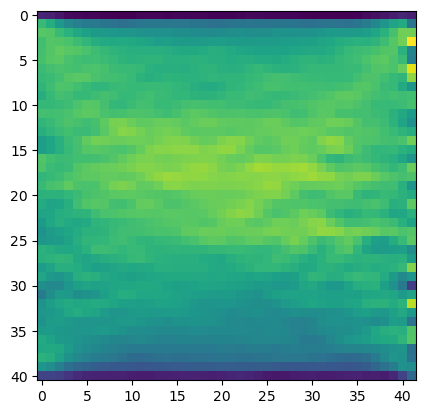

In [88]:
F_T = np.transpose(F, axes=(0, 1, 3, 2))
C = np.einsum('ijkl,ijlm->ijkm', F_T, F)
C = C.transpose([1,0,2,3])
plt.imshow((C[:,:,1,1]-1)*0.5)

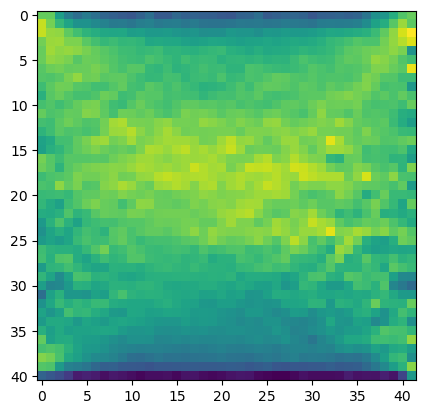

In [89]:
plt.imshow(df['Axial strain Eyy - GL [S]'].to_numpy().reshape([42,43])[:-1,:-1])

In [90]:
with open('manu/stiff1_hetero.npy', 'wb') as f:
    pickle.dump([x,y,F_hist], f)

### Stiff2_Hetero

In [112]:
out = []

for i in tqdm(range(1,158)):
    df = pd.read_csv('manu/Stiff2_Hetero_Final_42x41/Stiff2_Hetero_Final%04d.csv' % i, delimiter=';')
    Nx = 43

    uy = df['y-displacement [pixel]'].to_numpy()
    ux = df['x-displacement [pixel]'].to_numpy()
    uy = uy.reshape((-1,Nx))
    ux = ux.reshape((-1,Nx))

    ux_coeff = process_image(ux)
    uy_coeff = process_image(uy)

    F = np.stack((ux_coeff[:,:,:2], uy_coeff[:,:,:2]), axis = -1)/8 + np.eye(2)[None,None,:,:]
    F = F[2:-1,:-2] # For some reason F is 43x42 whereas Manu says it is 42x41? Plus, the edge pixels looks artifacty

    F = F.transpose([1,0,2,3])
    temp = F.reshape([-1,2,2])
    out.append(temp)
F_hist = np.array(out)

x = df['x [pixel]'].to_numpy().reshape((-1,Nx))
y = df['y [pixel]'].to_numpy().reshape((-1,Nx))
x = (x - x.min())/(x.max() - x.min())
y = (y - y.min())/(y.max() - y.min())
x = x[2:-1,:-2]  # For some reason F is 43x42 whereas Manu says it is 42x41? Plus, the edge pixels looks artifacty
y = y[2:-1,:-2]

100%|██████████| 157/157 [00:22<00:00,  7.02it/s]


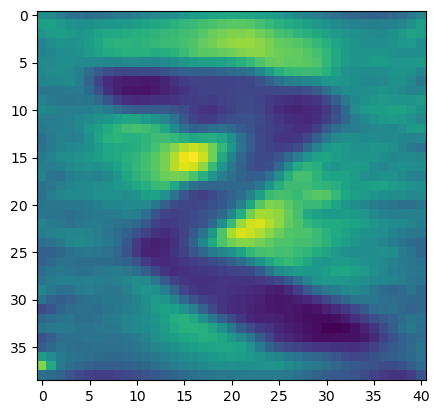

In [113]:
F_T = np.transpose(F, axes=(0, 1, 3, 2))
C = np.einsum('ijkl,ijlm->ijkm', F_T, F)
C = C.transpose([1,0,2,3])
plt.imshow((C[:,:,1,1]-1)*0.5)

In [114]:
with open('manu/stiff2_hetero.npy', 'wb') as f:
    pickle.dump([x,y,F_hist], f)

### Stiff3_Hetero

In [104]:
out = []

for i in tqdm(range(1,158)):
    df = pd.read_csv('manu/Stiff3_Hetero_Final_42x41/Stiff3_Hetero_Final%04d.csv' % i, delimiter=';')
    Nx = 43

    uy = df['y-displacement [pixel]'].to_numpy()
    ux = df['x-displacement [pixel]'].to_numpy()
    uy = uy.reshape((-1,Nx))
    ux = ux.reshape((-1,Nx))

    ux_coeff = process_image(ux)
    uy_coeff = process_image(uy)

    F = np.stack((ux_coeff[:,:,:2], uy_coeff[:,:,:2]), axis = -1)/8 + np.eye(2)[None,None,:,:]
    F = F[:-1,:-1] # For some reason F is 43x42 whereas Manu says it is 42x41? Plus, the last pixel looks artifacty

    F = F.transpose([1,0,2,3])
    temp = F.reshape([-1,2,2])
    out.append(temp)
F_hist = np.array(out)

x = df['x [pixel]'].to_numpy().reshape((-1,Nx))
y = df['y [pixel]'].to_numpy().reshape((-1,Nx))
x = (x - x.min())/(x.max() - x.min())
y = (y - y.min())/(y.max() - y.min())
x = x[:-1,:-1]  # For some reason F is 43x42 whereas Manu says it is 42x41? Plus, the last pixel looks artifacty
y = y[:-1,:-1]

100%|██████████| 157/157 [00:22<00:00,  6.94it/s]


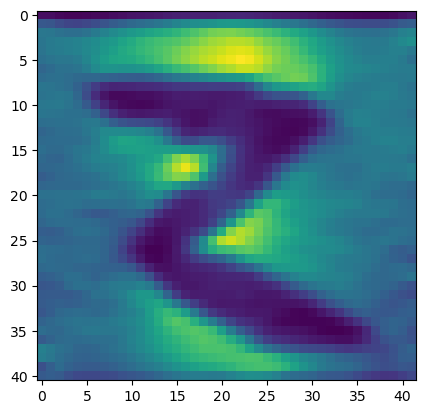

In [105]:
F_T = np.transpose(F, axes=(0, 1, 3, 2))
C = np.einsum('ijkl,ijlm->ijkm', F_T, F)
C = C.transpose([1,0,2,3])
plt.imshow((C[:,:,1,1]-1)*0.5)

In [106]:
with open('manu/stiff3_hetero.npy', 'wb') as f:
    pickle.dump([x,y,F_hist], f)